In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from n_framework import*
from activations_module import *

In [ ]:
clean_mem()

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#|export
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

### Going Deeper 
* with deeper with one more filter(channel) 64 -> 128

In [ ]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1,8,stride=1,act=act,norm=norm)]
    layers += [conv(nfs[i],nfs[i+1],act=act,norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers,conv(nfs[-1],10,act=None,norm=norm, bias=True),nn.Flatten()).to(def_device)

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5
tmax = epochs * len(dls.train)
model =get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
sched = partial(lr_scheduler.OneCycleLR,max_lr=lr, total_steps=tmax)
xtra= [BatchschedCB(sched)]
learn = TrainLearner(model,dls, F.cross_entropy,lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.806,0.702,0,train
0.865,0.409,0,eval
0.882,0.341,1,train
0.866,0.374,1,eval
0.906,0.267,2,train
0.886,0.323,2,eval
0.922,0.214,3,train
0.912,0.255,3,eval
0.940,0.171,4,train
0.919,0.228,4,eval


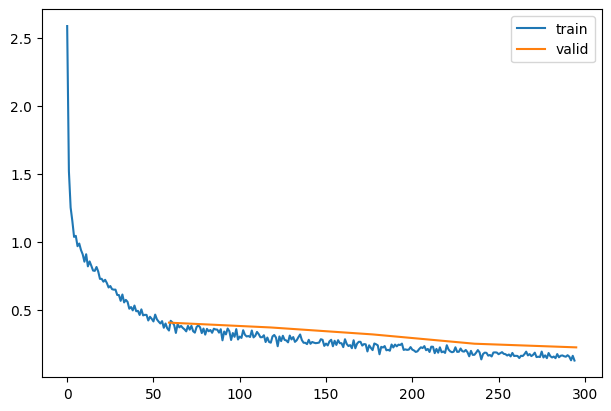

In [ ]:
learn.fit(epochs)

### Skip connections / Residual (ResNet)

In [ ]:
#|export
def _conv_block(ni, nf, stride, act= act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                        conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs  = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool   = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act    = act() 
        
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
#|export ....
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm = nn.BatchNorm2d):
    layers = [ResBlock(1,8,stride=1,act=act,norm=norm)]
    layers += [ResBlock(nfs[i],nfs[i+1],act=act,norm=norm,stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10,bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
def _print_shape(hook,mod, inp,outp): print(type(mod).__name__,inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls,F.cross_entropy,cbs = [DeviceCB(),SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
ResBlock torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
ResBlock torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
ResBlock torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
ResBlock torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
ResBlock torch.Size([1024, 128, 2, 2]) torch.Size([1024, 256, 1, 1])
Flatten torch.Size([1024, 256, 1, 1]) torch.Size([1024, 256])
Linear torch.Size([1024, 256]) torch.Size([1024, 10])
BatchNorm1d torch.Size([1024, 10]) torch.Size([1024, 10])


In [ ]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot=0
    def _f(hook,mod,inp,outp):
        nonlocal res,tot
        nparams = sum(o.numel() for o in mod.parameters())
        tot += nparams
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1,lr=1, train=False, cbs=SingleBatchCB())
    print("Total Parameters of the model: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
TrainLearner(get_model(), dls,F.cross_entropy,cbs=DeviceCB()).summary()

Total Parameters of the model:  1227396


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|688|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3648|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14464|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57600|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|229888|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|918528|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2560|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


In [ ]:
[o.shape for o in get_model().parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8, 8, 3, 3]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8, 1, 1, 1]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 8, 1, 1]),
 torch.Size([32, 16, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 16, 1, 1]),
 torch.Size([64, 32, 3, 3]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64, 64, 3, 3]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64, 32, 1, 1]),
 torch.Size([128, 64, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 128, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 64, 1, 1]),
 torch.Size([256, 128, 3, 3]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256, 256, 3, 3]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256, 128, 1, 1]),
 torch.Size([10,

In [ ]:
clean_mem()

In [ ]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epoch=10):
    self.fit(max_epoch, lr=start_lr,cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

In [ ]:
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy,cbs=DeviceCB()).lr_find()

TypeError: MomentumLearner.__init__() missing 1 required positional argument: 'lr'

In [ ]:
lr=2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra =[BatchschedCB(sched)]
model = get_model(act_gr, norm = nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs = cbs+xtra, opt_func = optim.AdamW)

accuracy,loss,epoch,train
0.817,0.709,0,train
0.826,0.542,0,eval
0.895,0.348,1,train
0.884,0.344,1,eval
0.914,0.259,2,train
0.904,0.277,2,eval
0.933,0.199,3,train
0.917,0.243,3,eval
0.952,0.149,4,train
0.923,0.223,4,eval


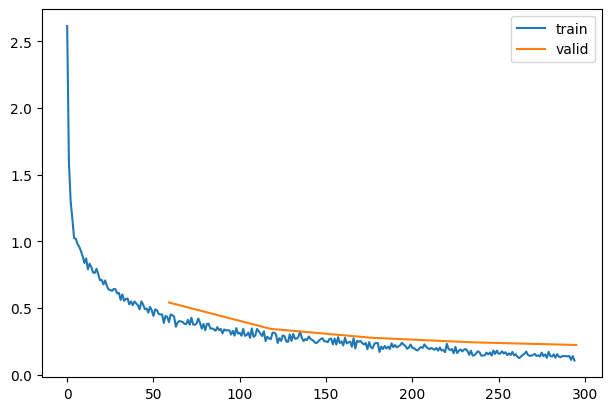

In [ ]:
learn.fit(epochs)

In [ ]:
import timm
from timm.models.resnet import BasicBlock,ResNet, Bottleneck

In [ ]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight gcresnet33ts gcresnet50t inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50c resnet50d resnet50s resnet50t resnet51q resnet61q resnet101 resnet101c resnet101d resnet101s resnet152 resnet152c resnet152d resnet152s resnet200 resnet200d resnetaa34d resnetaa50 resnetaa50d resnetaa101d resnetblur18 resnetblur50 resnetblur50d resnetblur101d resnetrs50 resnetrs101 resnetrs152 resnetrs200 resnetrs270 resnetrs350 resnetrs420 resne

In [ ]:
model = timm.create_model('resnet18d', in_chans=1,num_classes=10)

In [ ]:
lr=2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra =[BatchschedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs = cbs+xtra, opt_func = optim.AdamW)

accuracy,loss,epoch,train
0.778,0.642,0,train
0.498,2.408,0,eval
0.873,0.341,1,train
0.838,0.473,1,eval
0.908,0.251,2,train
0.863,0.378,2,eval
0.928,0.194,3,train
0.913,0.238,3,eval
0.945,0.148,4,train
0.921,0.219,4,eval


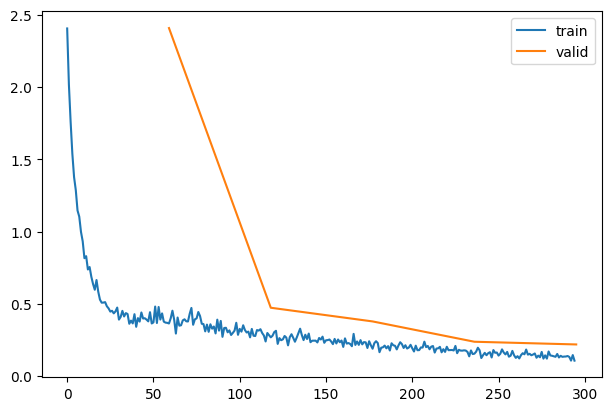

In [ ]:
learn.fit(epochs)